# Comparison velocities and acceleration computations

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
import dask.array as da

# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt
import hvplot.pandas
import holoviews as hv


import drifters.utils as ut
import pynsitu as pin

from dask.delayed import delayed

import GDP_lib as gdp

from GDP_lib import root_dir

In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client

    # cluster = PBSCluster()
    # w = cluster.scale(jobs=3) # 2 not enough for lon, lat, year, binning
    cluster = PBSCluster(cores=3, processes=3, walltime="04:00:00")
    w = cluster.scale(jobs=8)
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

<Client: 'tcp://10.148.0.70:45462' processes=0 threads=0, memory=0 B>

In [3]:
parquet_argos = os.path.join(root_dir, "argos_av_time.parquet")
parquet_gps = os.path.join(root_dir, "gps_av_time.parquet")

In [4]:
df_gps = dd.read_parquet(parquet_gps).persist()
df_argos = dd.read_parquet(parquet_argos).persist()

In [5]:
len(df_gps)

40800454

In [6]:
len(df_argos)

126136175

_____
## Trajectories

In [7]:
list_id = list(df_gps.get_partition(0).compute().groupby("id").groups.keys())
_id = list_id[0]
grp_id = (
    df_gps.get_partition(0)
    .groupby("id")
    .get_group(_id)
    .set_index("time")
    .rename(columns={"vex": "vex_geoid", "vny": "vny_geoid"})
    .compute()
)
# grp_idw = df_gw.get_partition(0).groupby('id').get_group(_id).set_index('time').rename(columns={'vex':'vex_diff', 'vny':'vny_diff'}).compute()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask/dataframe/core.py:4948: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [8]:
hvplot = (
    grp_id["x"].hvplot(grid=True)
    + grp_id["y"].hvplot(grid=True)
    + grp_id["ve"].hvplot(grid=True)
    * grp_id["vex_geoid"].hvplot()
    * grp_id["vex_diff"].hvplot()
    + grp_id["vn"].hvplot(grid=True)
    * grp_id["vny_geoid"].hvplot(grid=True)
    * grp_id["vny_diff"].hvplot(grid=True)
    + grp_id["ae"].hvplot(grid=True) * grp_id["aex"].hvplot(grid=True)
    + grp_id["an"].hvplot(grid=True) * grp_id["any"].hvplot(grid=True)
)
layout = hv.Layout(hvplot).cols(2)

layout

:Layout
   .Curve.X     :Curve   [time]   (x)
   .Curve.Y     :Curve   [time]   (y)
   .Overlay.I   :Overlay
      .Curve.Ve        :Curve   [time]   (ve)
      .Curve.Vex_geoid :Curve   [time]   (vex_geoid)
      .Curve.Vex_diff  :Curve   [time]   (vex_diff)
   .Overlay.II  :Overlay
      .Curve.Vn        :Curve   [time]   (vn)
      .Curve.Vny_geoid :Curve   [time]   (vny_geoid)
      .Curve.Vny_diff  :Curve   [time]   (vny_diff)
   .Overlay.III :Overlay
      .Curve.Ae  :Curve   [time]   (ae)
      .Curve.Aex :Curve   [time]   (aex)
   .Overlay.IV  :Overlay
      .Curve.An  :Curve   [time]   (an)
      .Curve.Any :Curve   [time]   (any)

_____
## Energies per drifters


In [9]:
df_gps["ve2"] = df_gps.ve**2
df_gps["vn2"] = df_gps.vn**2
df_gps["vex2"] = df_gps.vex**2
df_gps["vny2"] = df_gps.vny**2

__________
## Global mean/variance/std 
- no significative difference between ven (Elipot computation) and vxy (differenciation)
- difference between aen (Elipot computation differentiation) and axy (differenciation) -> difference centered or double differenciation methods ?

In [10]:
def print_mean_var(df):
    for l in df.columns:
        print(
            l
            + f": mean = {df[l].mean().compute()}, variance = {df[l].var().compute()}, std = {df[l].std().compute()}"
        )

In [11]:
print_mean_var(df_gps[["ve", "vn", "ae", "an", "vex", "vny", "aex", "any"]])

ve: mean = 0.011732471316373097, variance = 0.06279424577951431, std = 0.2505877912044525
vn: mean = 0.0032607036063863407, variance = 0.04795878008008003, std = 0.21899493038654327
ae: mean = -1.1537642964944862e-10, variance = 1.4307453105638039e-10, std = 1.1961376637176023e-05
an: mean = -7.098412886714269e-10, variance = 1.4415277088302127e-10, std = 1.2006363766062616e-05
vex: mean = 0.011906067074076267, variance = 0.06540513935982838, std = 0.2557442850971032
vny: mean = 0.003269491534485143, variance = 0.048388653621179036, std = 0.21997421126390937
aex: mean = -9.775045008728025e-09, variance = 6.252061165501734e-09, std = 7.90699763848563e-05
any: mean = 7.79599155912475e-09, variance = 2.7495817453369753e-09, std = 5.243645435512374e-05


In [12]:
print_mean_var(df_argos[["ve", "vn", "ae", "an", "vex", "vny", "aex", "any"]])

ve: mean = 0.0055001474596799846, variance = 0.07463309913873672, std = 0.27319058775901794
vn: mean = 0.005319764532260472, variance = 0.05263225734233856, std = 0.22941721975803375
ae: mean = -4.795563455350166e-10, variance = 3.0615418972009896e-10, std = 1.7497262349296217e-05
an: mean = 6.422381233372121e-12, variance = 2.33364135989755e-10, std = 1.5276260536851124e-05
vex: mean = 0.005490828122817307, variance = 0.08049072260169518, std = 0.28370886944488566
vny: mean = 0.0052898871453308125, variance = 0.053458274802922284, std = 0.23121045565225265
aex: mean = 1.0734500693792767e-08, variance = 6.0889647951329804e-09, std = 7.80318191197218e-05
any: mean = 4.779322459805883e-09, variance = 2.3220637182431757e-09, std = 4.818779636218257e-05


In [13]:
listv = ["ve", "vex", "vex_diff", "vn", "vny", "vny_diff"]
lista = ["ae", "aex", "an", "any"]


def list_std(df, listv_=listv, lista_=lista):
    stdv = []
    for l in listv_:
        stdv.append(df[l].std().compute())
    stda = []
    for l in lista_:
        stda.append(df[l].std().compute())
    return np.array(stdv), np.array(stda)


stdv_a, stda_a = list_std(df_argos)
stdv_g, stda_g = list_std(df_gps)

In [14]:
stdv_a**2

array([ 0.0746331 ,  0.08049072, 51.7699031 ,  0.05263226,  0.05345827,
        9.67361149])

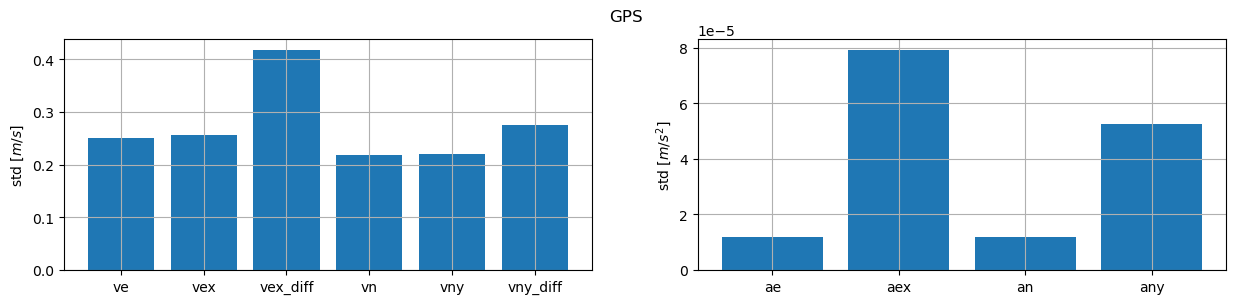

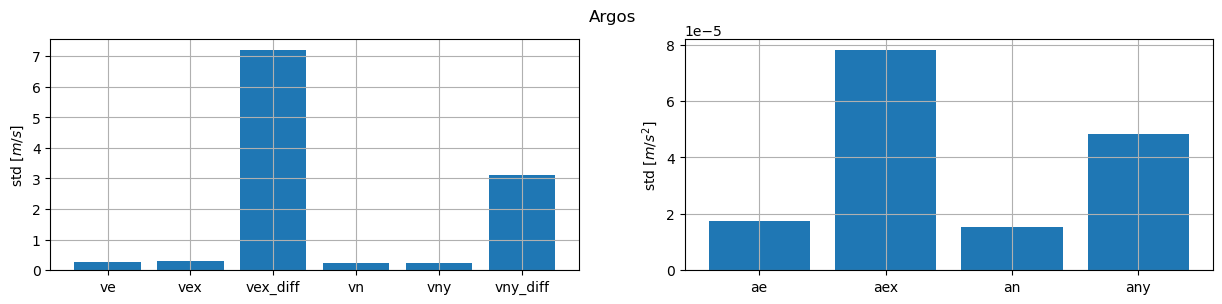

In [15]:
def print_std(listv, stdv, lista, stda, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    axs = axs.flatten()
    axs[0].grid()
    axs[1].grid()
    axs[0].bar(listv, stdv)
    axs[1].bar(lista, stda)
    axs[0].set_ylabel(r"std $[m/s]$")
    axs[1].set_ylabel(r"std $[m/s^2]$")
    fig.suptitle(title)


print_std(listv, stdv_g, lista, stda_g, "GPS")
print_std(listv, stdv_a, lista, stda_a, "Argos")

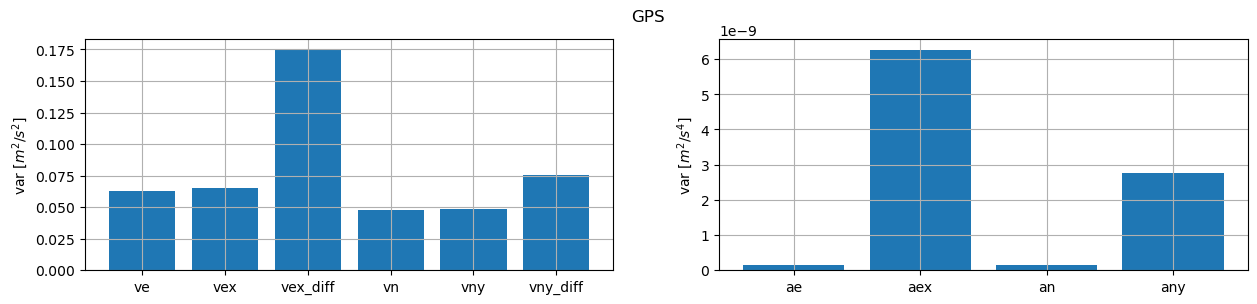

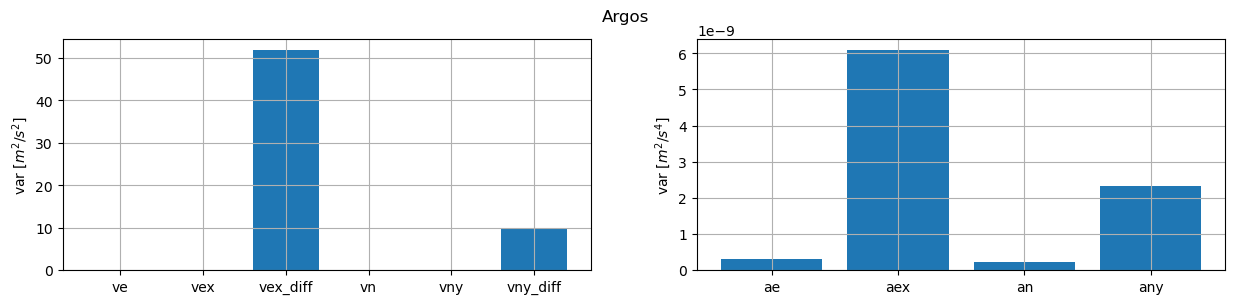

In [16]:
def print_var(listv, stdv, lista, stda, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    axs = axs.flatten()
    axs[0].grid()
    axs[1].grid()
    axs[0].bar(listv, stdv**2)
    axs[1].bar(lista, stda**2)
    axs[0].set_ylabel(r"var $[m^2/s^2]$")
    axs[1].set_ylabel(r"var $[m^2/s^4]$")
    fig.suptitle(title)


print_var(listv, stdv_g, lista, stda_g, "GPS")
print_var(listv, stdv_a, lista, stda_a, "Argos")

- $a_{e,n}$ are computed from ve,n by a centered differenciation :
$$ \langle a^2_{e,n} \rangle = \frac{\langle v_{e,n}^2 \rangle - C_u(2dt)}{2dt^2}$$
- $a_{x,y}$ are computed from x,y by two simple differenciations :
$$ \langle a^2_{x,y} \rangle = 2\frac{\langle v_{x,y}^2 \rangle - C_u(dt)}{dt^2}$$

This might explain the observed difference

______________
## Dependence on x,y
- no significative trend

In [17]:
def add_diff_va(df):
    df["ae-aex"] = df["ae"] - df["aex"]
    df["an-any"] = df["an"] - df["any"]
    df["ve-vex"] = df["ve"] - df["vex"]
    df["vn-vny"] = df["vn"] - df["vny"]
    df["ae-aex/ae"] = df["ae-aex"] / df["ae"]
    df["an-any/an"] = df["an-any"] / df["an"]
    df["ve-vex/ve"] = df["ve-vex"] / df["ve"]
    df["vn-vny/vn"] = df["vn-vny"] / df["vn"]


add_diff_va(df_gps)
add_diff_va(df_argos)

In [18]:
def deriv_dep2_x(df):
    xmin = (df["x"].min()).compute()
    xmax = (df["x"].max()).compute()

    # delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    xbins = np.arange(xmin, xmax, 500)  # 10min binning
    df["xcut"] = df["x"].map_partitions(pd.cut, xbins)
    mean = (
        df[
            [
                "ae-aex",
                "an-any",
                "ve-vex",
                "vn-vny",
                "ae-aex/ae",
                "an-any/an",
                "ve-vex/ve",
                "vn-vny/vn",
            ]
        ]
        .groupby(df.xcut)
        .mean()
        .compute()
        .rename(
            columns={
                l: "mean_" + l
                for l in [
                    "ae-aex",
                    "an-any",
                    "ve-vex",
                    "vn-vny",
                    "ae-aex/ae",
                    "an-any/an",
                    "ve-vex/ve",
                    "vn-vny/vn",
                ]
            }
        )
        # .to_frame() ALREADY A DATAFRAME
    )
    mean["x"] = mean.index.to_series().apply(lambda d: d.mid)
    mean = mean.set_index("x")

    ds = (
        mean
        # .drop(columns=["year",])
        .to_xarray()
    )
    return ds

In [19]:
def deriv_dep2_y(df):
    xmin = (df["y"].min()).compute()
    xmax = (df["y"].max()).compute()

    # delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    xbins = np.arange(xmin, xmax, 500)  # 10min binning
    df["ycut"] = df["y"].map_partitions(pd.cut, xbins)
    mean = (
        df[
            [
                "ae-aex",
                "an-any",
                "ve-vex",
                "vn-vny",
                "ae-aex/ae",
                "an-any/an",
                "ve-vex/ve",
                "vn-vny/vn",
            ]
        ]
        .groupby(df.ycut)
        .mean()
        .compute()
        .rename(
            columns={
                l: "mean_" + l
                for l in [
                    "ae-aex",
                    "an-any",
                    "ve-vex",
                    "vn-vny",
                    "ae-aex/ae",
                    "an-any/an",
                    "ve-vex/ve",
                    "vn-vny/vn",
                ]
            }
        )
        # .to_frame() ALREADY A DATAFRAME
    )
    mean["y"] = mean.index.to_series().apply(lambda d: d.mid)
    mean = mean.set_index("y")

    ds = (
        mean
        # .drop(columns=["year",])
        .to_xarray()
    )
    return ds

In [20]:
ds_x_gps = deriv_dep2_x(df_gps)
ds_y_gps = deriv_dep2_y(df_gps)

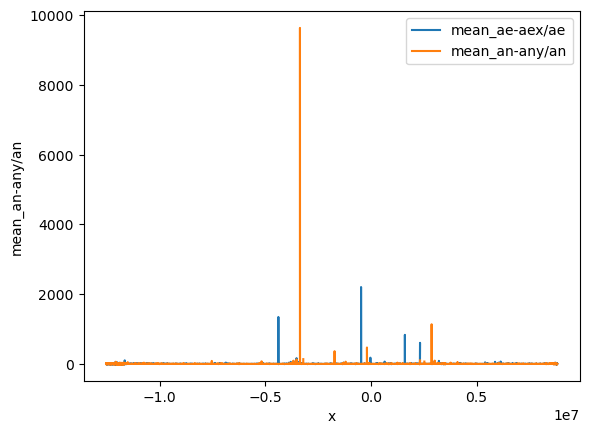

In [21]:
abs(ds_x_gps["mean_ae-aex/ae"]).plot(label="mean_ae-aex/ae")
abs(ds_x_gps["mean_an-any/an"]).plot(label="mean_an-any/an")
plt.legend()

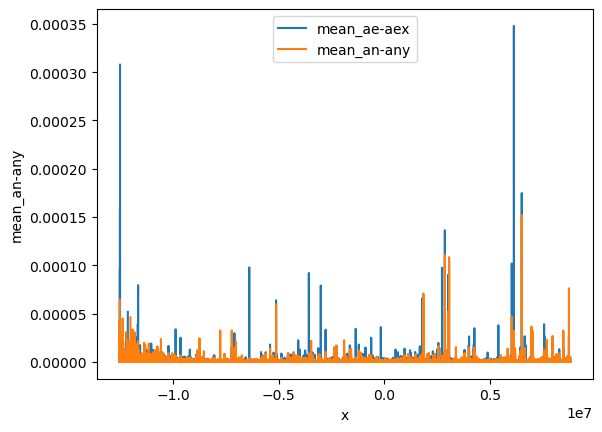

In [22]:
abs(ds_x_gps["mean_ae-aex"]).plot(label="mean_ae-aex")
abs(ds_x_gps["mean_an-any"]).plot(label="mean_an-any")
plt.legend()

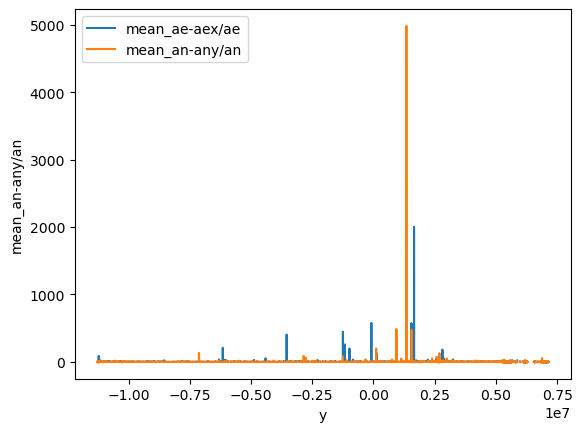

In [23]:
abs(ds_y_gps["mean_ae-aex/ae"]).plot(label="mean_ae-aex/ae")
abs(ds_y_gps["mean_an-any/an"]).plot(label="mean_an-any/an")
plt.legend()

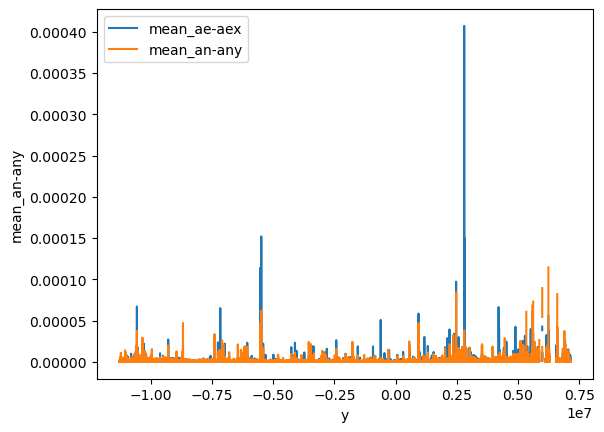

In [24]:
abs(ds_y_gps["mean_ae-aex"]).plot(label="mean_ae-aex")
abs(ds_y_gps["mean_an-any"]).plot(label="mean_an-any")
plt.legend()

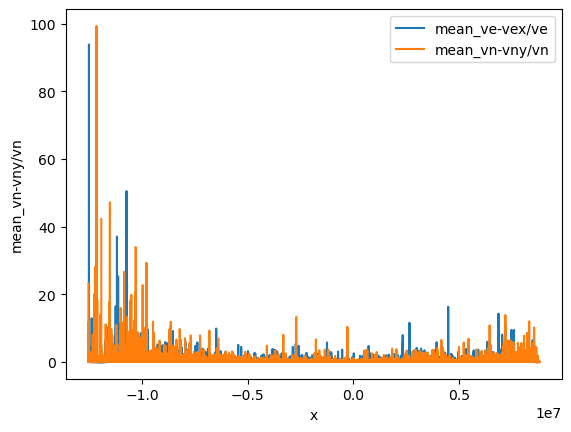

In [25]:
abs(ds_x_gps["mean_ve-vex/ve"]).plot(label="mean_ve-vex/ve")
abs(ds_x_gps["mean_vn-vny/vn"]).plot(label="mean_vn-vny/vn")
plt.legend()

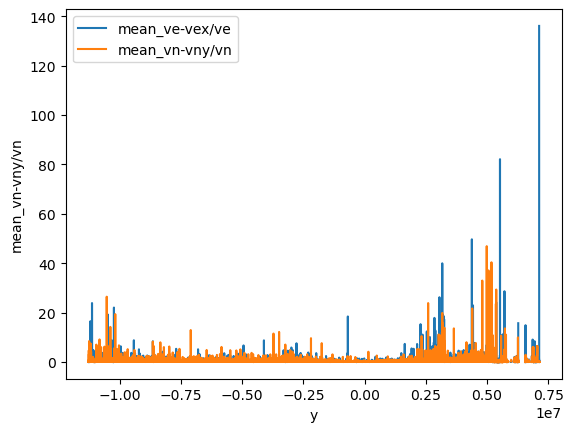

In [26]:
abs(ds_y_gps["mean_ve-vex/ve"]).plot(label="mean_ve-vex/ve")
abs(ds_y_gps["mean_vn-vny/vn"]).plot(label="mean_vn-vny/vn")
plt.legend()

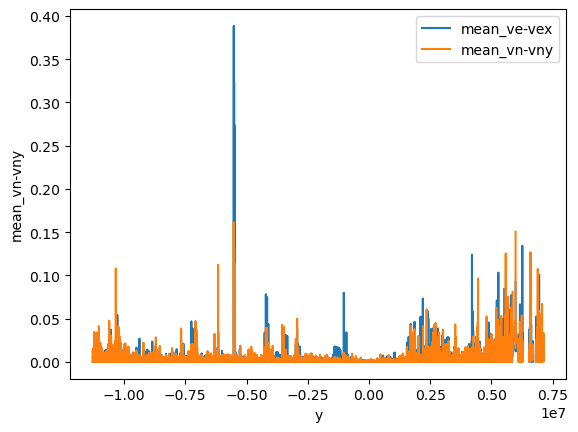

In [27]:
abs(ds_y_gps["mean_ve-vex"]).plot(label="mean_ve-vex")
abs(ds_y_gps["mean_vn-vny"]).plot(label="mean_vn-vny")
plt.legend()

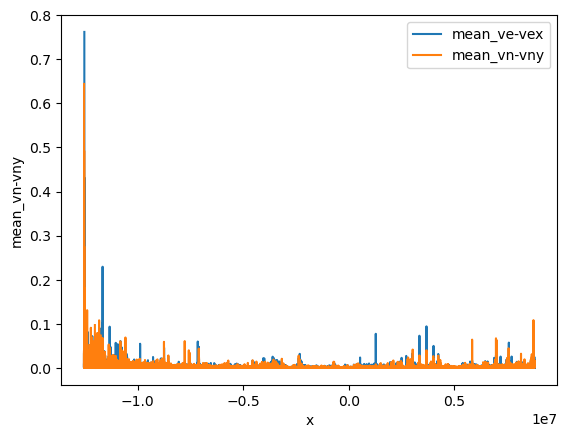

In [28]:
abs(ds_x_gps["mean_ve-vex"]).plot(label="mean_ve-vex")
abs(ds_x_gps["mean_vn-vny"]).plot(label="mean_vn-vny")
plt.legend()

___
## Dependence on the gap
- difference seem to depend on the gap 

In [29]:
def deriv_dep2_gap(df):
    gap_min = (df["gap"].min()).compute()
    gap_max = (df["gap"].max()).compute()

    # delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    gap_bins = np.arange(gap_min, gap_max, 1800)  # 10min binning
    df["gap_cut"] = df["gap"].map_partitions(pd.cut, gap_bins)
    mean_gap = (
        df[["ae-aex/ae", "an-any/an", "ve-vex/ve", "vn-vny/vn"]]
        .groupby(df.gap_cut)
        .mean()
        .compute()
        .rename(
            columns={
                l: "mean_" + l
                for l in ["ae-aex/ae", "an-any/an", "ve-vex/ve", "vn-vny/vn"]
            }
        )
        # .to_frame() ALREADY A DATAFRAME
    )
    mean_gap["gap"] = mean_gap.index.to_series().apply(lambda d: d.mid)
    mean_gap = mean_gap.set_index("gap")

    ds = (
        mean_gap
        # .drop(columns=["year",])
        .to_xarray()
    )
    ds["gap"] = ds["gap"] / 3600  # gap in hours
    return ds

In [30]:
ds_gap_gps = deriv_dep2_gap(df_gps)

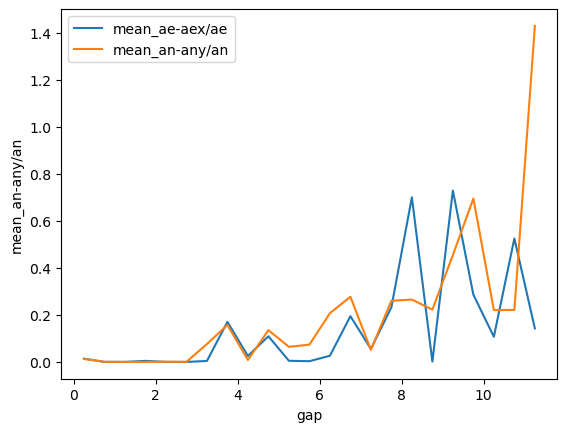

In [31]:
abs(ds_gap_gps["mean_ae-aex/ae"]).plot(label="mean_ae-aex/ae")
abs(ds_gap_gps["mean_an-any/an"]).plot(label="mean_an-any/an")
plt.legend()

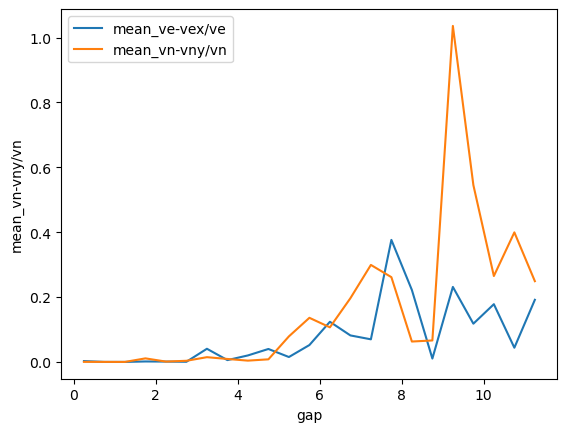

In [32]:
abs(ds_gap_gps["mean_ve-vex/ve"]).plot(label="mean_ve-vex/ve")
abs(ds_gap_gps["mean_vn-vny/vn"]).plot(label="mean_vn-vny/vn")
plt.legend()

In [34]:
cluster.close()